# Analyze RAGIS ensmbles

In [1]:
from datetime import datetime
import numpy as np
import pylab as plt
import pandas as pd
from pathlib import Path
import os

import seaborn as sns

from pismragis.observations import load_imbie, load_mouginot, load_mankoff, plot_observations, plot_multiple_observations
from pismragis.analysis import resample_ensemble_by_data, sensitivity_analysis
from pismragis.processing import convert_netcdf_to_dataframe, check_file, copy_file, to_decimal_year
from pismragis.stats import run_stats

## Some settings

In [2]:
# Root directory
data_dir = Path("/Users/andy/Google Drive/My Drive/Projects/RAGIS/data/pism")
assert data_dir.exists()
results_dir = "2023_10_tw_ocean_calving_analyis"
o_dir = data_dir / results_dir
o_dir.mkdir(exist_ok=True)
fig_dir = o_dir / "figures"
fig_dir.mkdir(exist_ok=True)
# Number of parallel jobs
n_jobs = 4
# Normalization year (1992 IMBIE)
norm_year = 1992

In [3]:

plt.rc('font', size=6)
plt.style.use("tableau-colorblind10")

mass_varname = "SLE (cm)"
mass_uncertainty_varname = "SLE uncertainty (cm)"
discharge_varname = "Rate of ice discharge (Gt/yr)"
discharge_uncertainty_varname = "Rate of ice discharge uncertainty (Gt/yr)"
smb_varname = "Rate of surface mass balance (Gt/yr)"
smb_uncertainty_varname = "Rate of surface mass balance uncertainty (Gt/yr)"

bg_color = "w"
sim_colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][1::]
imbie_color = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]

sim_colors = [ "#d73027",  "#4575b4", "#fc8d59", "#91bfdb", "#fee090"]

imbie_color = "#756bb1"
mou_color = "#54278f"

imbie_color = "0.4"
man_color = "0.3"
mou_color = "0.2"

    
kg2cmsle = 1 / 1e12 * 1.0 / 362.5 / 10.0
gt2cmsle = 1 / 362.5 / 10.0

## Load Observations

In [4]:
# imbie = load_imbie(url=Path("/Users/andy/Google Drive/My Drive/Projects/RAGIS/data/imbie_dataset_greenland_dynamics-2020_02_28.xlsx"))
imbie = load_imbie()
# Glacier and Ice cap bias 30 Gt/yr, add it back
imbie[mass_varname] -= 30 * gt2cmsle
imbie[smb_varname] += 30

mou = load_mouginot(url=Path("/Users/andy/Google Drive/My Drive/Projects/RAGIS/data/pnas.1904242116.sd02.xlsx"), norm_year=1980)
mou_gis = mou[mou["Basin"] == "GIS"]

mou_1992 = load_mouginot(url=Path("/Users/andy/Google Drive/My Drive/Projects/RAGIS/data/pnas.1904242116.sd02.xlsx"), norm_year=1992)
mou_gis_1992 = mou_1992[mou_1992["Basin"] == "GIS"]

man = load_mankoff()

## Make a list of all experiments

In [19]:
exps = []

# exps.append({
#     "Experiment": "GrIMP",
#     "proj_dir": "2023_10_grimp_ocean_calving_w_posterior_lhs_50",
#     "scalar_dir": "scalar",
#     "processed_dir": "processed",
#     "lhs": "gris_ragis_ocean_calving_w_posterior_lhs_50",
#     "DEM": "GRIMP"
# }
# )



# exps.append({
#     "Experiment": "RAGIS",
#     "proj_dir": "2023_10_ragis_ocean_calving_w_posterior_lhs_50",
#     "scalar_dir": "scalar",
#     "processed_dir": "processed",
#     "lhs": "gris_ragis_ocean_calving_w_posterior_lhs_50",
#     "DEM": "RAGIS"
# }
# )

exps.append({
    "Experiment": "GrIMP",
    "proj_dir": "2023_10_grimp_tw_ocean_calving_w_posterior_lhs_50",
    "scalar_dir": "scalar",
    "processed_dir": "processed",
    "lhs": "gris_ragis_ocean_calving_w_posterior_lhs_50",
    "DEM": "GRIMP",
    "resolution": 900
}
)



exps.append({
    "Experiment": "RAGIS",
    "proj_dir": "2023_10_ragis_tw_ocean_calving_w_posterior_lhs_50",
    "scalar_dir": "scalar",
    "processed_dir": "processed",
    "lhs": "gris_ragis_ocean_calving_w_posterior_lhs_50",
    "DEM": "RAGIS",
    "resolution": 900
}
)


## Process experiments

In [20]:
experiments = []

for exp in exps:
    print(f"""Processing {exp["Experiment"]}""")
    print("================================================\n")
    ens_file = data_dir / exp["proj_dir"] / "uq" /f"""{exp["lhs"]}.csv"""
    s_dir = data_dir / exp["proj_dir"] / exp["scalar_dir"]
    scalar_files = sorted(s_dir.glob(f"""ts_gris_g{exp["resolution"]}m_*{exp["DEM"]}_id_*_1980-1-1_2020-1-1.nc"""))
    processed_path = data_dir / exp["proj_dir"] / exp["processed_dir"]
    for scalar_file in scalar_files:
        if check_file(scalar_file):
            copy_file(scalar_file, processed_path)
        
    processed_files = sorted(processed_path.glob(f"""ts_gris_g{exp["resolution"]}m_*{exp["DEM"]}_id_*_1980-1-1_2020-1-1.nc"""))
    exp_df = convert_netcdf_to_dataframe(processed_files, resample="yearly", verbose=False, n_jobs=n_jobs, norm_year=1980)
    exp_df["Experiment"] = exp["Experiment"]
    exp["data_df"] = exp_df
    exp["run_stats"] = run_stats(processed_files, experiment=exp["Experiment"])
    try:
        sa_df = sensitivity_analysis(exp_df.dropna(), ensemble_file=ens_file, n_jobs=n_jobs)
        exp["sensitivity_df"] = sa_df
    except:
        pass
    experiments.append(exp)


Processing GrIMP

/Users/andy/Google Drive/My Drive/Projects/RAGIS/data/pism/2023_10_grimp_tw_ocean_calving_w_posterior_lhs_50/scalar/ts_gris_g900m_v2023_GRIMP_id_13_1980-1-1_2020-1-1.nc time-series too short or not monotonically-increasing.
/Users/andy/Google Drive/My Drive/Projects/RAGIS/data/pism/2023_10_grimp_tw_ocean_calving_w_posterior_lhs_50/scalar/ts_gris_g900m_v2023_GRIMP_id_46_1980-1-1_2020-1-1.nc time-series too short or not monotonically-increasing.
Converting netcdf files to pandas.DataFrame
-------------------------------------------


Processing files: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:02<00:00,  9.14it/s]


Conversion finished in 3 seconds
-------------------------------------------
-------------------------------------------

Processing RAGIS

/Users/andy/Google Drive/My Drive/Projects/RAGIS/data/pism/2023_10_ragis_tw_ocean_calving_w_posterior_lhs_50/scalar/ts_gris_g900m_v2023_RAGIS_id_13_1980-1-1_2020-1-1.nc time-series too short or not monotonically-increasing.
/Users/andy/Google Drive/My Drive/Projects/RAGIS/data/pism/2023_10_ragis_tw_ocean_calving_w_posterior_lhs_50/scalar/ts_gris_g900m_v2023_RAGIS_id_14_1980-1-1_2020-1-1.nc time-series too short or not monotonically-increasing.
/Users/andy/Google Drive/My Drive/Projects/RAGIS/data/pism/2023_10_ragis_tw_ocean_calving_w_posterior_lhs_50/scalar/ts_gris_g900m_v2023_RAGIS_id_46_1980-1-1_2020-1-1.nc time-series too short or not monotonically-increasing.
Converting netcdf files to pandas.DataFrame
-------------------------------------------


Processing files: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 13.34it/s]


Conversion finished in 2 seconds
-------------------------------------------
-------------------------------------------



## Ensemble Performance Statistics

In [15]:
m_vars = ["processor_hours", "wall_clock_hours", "model_years_per_processor_hour"]
for m, e in enumerate(experiments):
    e_df = experiments[m]["run_stats"]
    print(f"""Peformace Summary for Experiment {e["Experiment"]} ({len(e_df)} members)""")
    print("---------------------------------------------------\n")
    print(e_df.agg({'processor_hours': 'sum', 'wall_clock_hours': "sum", "model_years_per_processor_hour": "mean"}))
    print("---------------------------------------------------\n")

Peformace Summary for Experiment GrIMP (25 members)
---------------------------------------------------

processor_hours                   82890.828484
wall_clock_hours                    690.756904
model_years_per_processor_hour        0.011666
dtype: float64
---------------------------------------------------

Peformace Summary for Experiment RAGIS (24 members)
---------------------------------------------------

processor_hours                   72966.078573
wall_clock_hours                    608.050655
model_years_per_processor_hour        0.013131
dtype: float64
---------------------------------------------------



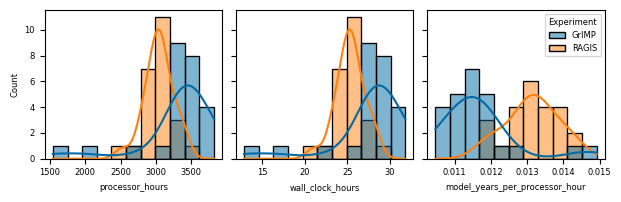

In [12]:
plt.rc('font', size=6)
plt.style.use("tableau-colorblind10")

fig, axs = plt.subplots(nrows=1, ncols=len(m_vars), sharey="row", figsize=[6.2, 2.0])
fig.subplots_adjust(wspace=0)


all_run_stats = pd.concat([experiments[k]["run_stats"] for k in range(len(experiments))]).reset_index(drop=True)
[sns.histplot(data=all_run_stats, x=m_var, bins=11, kde=True, hue="Experiment", ax=axs[k]) for k, m_var in enumerate(m_vars)]
axs[0].legend([], [], frameon=False)
axs[1].legend([], [], frameon=False)


fig.tight_layout()
run_stats_file = fig_dir / "run_stats.pdf"
fig.savefig(run_stats_file)

## Plot

Plot time series of cumulative mass change (cm SLE) and discharge at grounding line (Gt/yr)

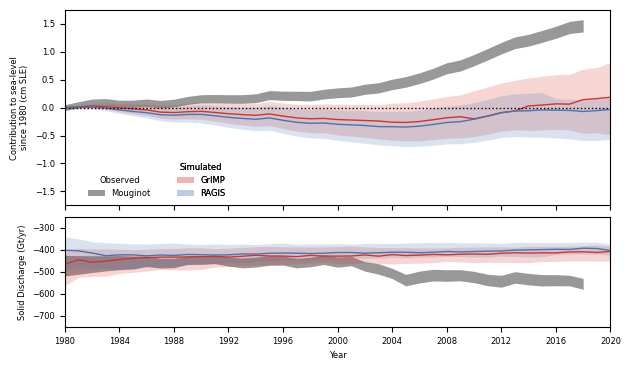

In [8]:
sigma_mass = 1 
sigma_discharge = 2


plot_experiments = experiments

plt.rc('font', size=6)
plt.style.use("tableau-colorblind10")

fig, axs = plt.subplots(nrows=2, ncols=1, sharex="col", figsize=(6.2, 3.6), height_ratios=[16, 9])
fig.subplots_adjust(wspace=0, hspace=0.075, bottom=0.1, top=0.98, left=0.1, right=0.98)


for obs, o, obs_color, obs_loc, obs_alpha  in zip([mou_gis], ["Mouginot"], 
                                       [mou_color], [(0.1, 0.0)], [0.5]):
    obs_ci = axs[0].fill_between(obs["Date"], 
                    (obs[mass_varname] + sigma_mass * obs[mass_uncertainty_varname]), 
                    (obs[mass_varname] - sigma_mass * obs[mass_uncertainty_varname]), 
                    ls="solid", color=obs_color, lw=0, alpha=obs_alpha, label=o)
    axs[1].fill_between(obs["Date"], 
                    (obs[discharge_varname] + sigma_discharge * obs[discharge_uncertainty_varname]), 
                    (obs[discharge_varname] - sigma_discharge * obs[discharge_uncertainty_varname]), 
                    ls="solid", color=obs_color, lw=0, alpha=obs_alpha)


legend_obs = axs[0].legend(loc="lower center", bbox_to_anchor=obs_loc, title="Observed")
legend_obs.get_frame().set_linewidth(0.0)
legend_obs.get_frame().set_alpha(0.0)
axs[0].add_artist(legend_obs)


sims_cis = []
sims_lines = []
for k, exp in enumerate(plot_experiments):
    df = exp["data_df"]
    q_16 = df.groupby(by="time").quantile(0.16, numeric_only=True)
    q_50 = df.groupby(by="time").quantile(0.50, numeric_only=True)
    q_84 = df.groupby(by="time").quantile(0.84, numeric_only=True)
    sims_line = axs[0].plot(q_50.index, q_50[mass_varname], color=sim_colors[k], alpha=1.0, lw=1)
    axs[1].plot(q_50.index, q_50[discharge_varname], color=sim_colors[k], alpha=1.0, lw=1)
    sims_ci = axs[0].fill_between(q_16.index, q_16[mass_varname], 
                        q_84[mass_varname], color=sim_colors[k], alpha=0.2, lw=0, label=exp["Experiment"])
    axs[1].fill_between(q_16.index, q_16[discharge_varname], 
                        q_84[discharge_varname], color=sim_colors[k], alpha=0.2, lw=0)
    sims_cis.append(sims_ci)
    sims_lines.append(sims_line[0])

if len(sims_cis) < 4:
    ncols = 1
else:
    ncols = 2
legend_sims = axs[0].legend(handles=sims_cis, loc="lower center", bbox_to_anchor=[0.25, .0], 
                           title=f"Simulated", ncols=ncols)
legend_sims.get_frame().set_linewidth(0.0)
legend_sims.get_frame().set_alpha(0.0)
axs[0].add_artist(legend_sims)
    



fig.set_facecolor(bg_color)
for ax in axs:
    ax.set_facecolor(bg_color)
fig.set_facecolor(bg_color)

axs[0].axhline(0, color="k", ls="dotted", lw=1.0)
axs[0].set_xlabel("")
axs[0].set_ylabel("Contribution to sea-level\nsince 1980 (cm SLE)")
axs[-1].set_xlabel("Year")
axs[1].set_ylabel("Solid Discharge (Gt/yr)")
axs[0].set_xlim(pd.to_datetime("1980-1-1"), pd.to_datetime("2020-1-1"))
axs[0].set_ylim(-1.75, 1.75)
axs[1].set_ylim(-750, -250)

# fig.tight_layout()
fig.savefig(fig_dir / "ragis-comp_scalar_1980-2020.pdf")
fig.savefig(fig_dir / "ragis-comp_scalar_1980-2020.png", dpi=600)

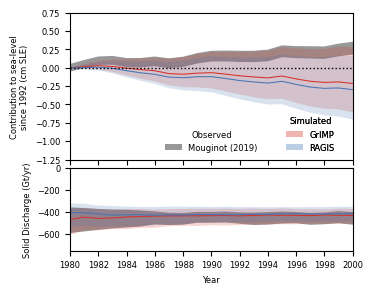

In [9]:
imbie[[discharge_uncertainty_varname]].mean() / mou_gis[[discharge_uncertainty_varname]].mean()
sigma_mass = 1
sigma_discharge = 5
plot_experiments = [experiments[0], experiments[1]]

plt.rc('font', size=6)
plt.style.use("tableau-colorblind10")

fig, axs = plt.subplots(nrows=2, ncols=1, sharex="col", figsize=(3.6, 2.8), height_ratios=[16, 9])
fig.subplots_adjust(wspace=0, hspace=0.075, bottom=0.125, top=0.975, left=0.175, right=0.96)


for obs, o, obs_color, obs_loc, obs_alpha  in zip([mou_gis], ["Mouginot (2019)"], 
                                       [mou_color], [(0.5, 0.0)], [0.5]):
    if mass_varname in obs:
        obs_ci = axs[0].fill_between(obs["Date"], 
                        (obs[mass_varname] + sigma_mass * obs[mass_uncertainty_varname]), 
                        (obs[mass_varname] - sigma_mass * obs[mass_uncertainty_varname]), 
                        ls="solid", color=obs_color, lw=0, alpha=obs_alpha, label=o)
    axs[1].fill_between(obs["Date"], 
                    (obs[discharge_varname] + sigma_discharge * obs[discharge_uncertainty_varname]), 
                    (obs[discharge_varname] - sigma_discharge * obs[discharge_uncertainty_varname]), 
                    ls="solid", color=obs_color, lw=0, alpha=obs_alpha)

    legend_obs = axs[0].legend(handles=[obs_ci], loc="lower center", bbox_to_anchor=obs_loc, 
                               title="Observed")
    legend_obs.get_frame().set_linewidth(0.0)
    legend_obs.get_frame().set_alpha(0.0)
    axs[0].add_artist(legend_obs)


sims_cis = []
sims_lines = []
for k, exp in enumerate(plot_experiments):
    df = exp["data_df"]
    q_05 = df.groupby(by="time").quantile(0.05, numeric_only=True)
    q_50 = df.groupby(by="time").quantile(0.50, numeric_only=True)
    q_95 = df.groupby(by="time").quantile(0.95, numeric_only=True)
    sims_line = axs[0].plot(q_50.index, q_50[mass_varname], color=sim_colors[k], alpha=1.0, lw=0.75)
    axs[1].plot(q_50.index, q_50[discharge_varname], color=sim_colors[k], alpha=1.0, lw=0.75)
    sims_ci = axs[0].fill_between(q_05.index, q_05[mass_varname], 
                        q_95[mass_varname], color=sim_colors[k], alpha=0.2, lw=0, label=exp["Experiment"])
    axs[1].fill_between(q_05.index, q_05[discharge_varname], 
                        q_95[discharge_varname], color=sim_colors[k], alpha=0.2, lw=0)
    sims_cis.append(sims_ci)
    sims_lines.append(sims_line[0])

if len(sims_cis) < 4:
    ncols = 1
else:
    ncols = 2
legend_sims = axs[0].legend(handles=sims_cis, loc="lower center", bbox_to_anchor=[0.85, .0], 
                           title=f"Simulated", ncols=ncols)
legend_sims.get_frame().set_linewidth(0.0)
legend_sims.get_frame().set_alpha(0.0)
axs[0].add_artist(legend_sims)
    

fig.set_facecolor(bg_color)
for ax in axs:
    ax.set_facecolor(bg_color)
fig.set_facecolor(bg_color)

axs[0].axhline(0, color="k", ls="dotted", lw=1.0)
axs[0].set_xlabel("")
axs[0].set_ylabel("Contribution to sea-level\nsince 1992 (cm SLE)")
axs[-1].set_xlabel("Year")
axs[1].set_ylabel("Solid Discharge (Gt/yr)")
axs[0].set_xlim(pd.to_datetime("1980-1-1"), pd.to_datetime("2020-1-1"))
axs[0].set_ylim(-1.25, 0.75)
axs[1].set_ylim(-750, 0)

axs[0].set_xlim(pd.to_datetime("1980-1-1"), pd.to_datetime("2000-1-1"))
fig.savefig(fig_dir / "ragis-comp_scalar_1980-2000.pdf")
fig.savefig(fig_dir / "ragis-comp_scalar_1980-2000.png", dpi=600)

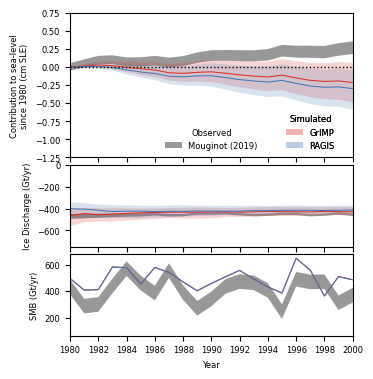

In [10]:
imbie[[discharge_uncertainty_varname]].mean() / mou_gis[[discharge_uncertainty_varname]].mean()
sigma_mass = 1
sigma_discharge = 1
sigma_smb = 1
plot_experiments = [experiments[0], experiments[1]]

plt.rc('font', size=6)
plt.style.use("tableau-colorblind10")

fig, axs = plt.subplots(nrows=3, ncols=1, sharex="col", figsize=(3.6, 3.8), height_ratios=[16, 9, 9])
fig.subplots_adjust(wspace=0, hspace=0.075, bottom=0.125, top=0.975, left=0.175, right=0.96)


for obs, o, obs_color, obs_loc, obs_alpha  in zip([mou_gis], ["Mouginot (2019)"], 
                                       [mou_color], [(0.5, 0.0)], [0.5]):
    if mass_varname in obs:
        obs_ci = axs[0].fill_between(obs["Date"], 
                        (obs[mass_varname] + sigma_mass * obs[mass_uncertainty_varname]), 
                        (obs[mass_varname] - sigma_mass * obs[mass_uncertainty_varname]), 
                        ls="solid", color=obs_color, lw=0, alpha=obs_alpha, label=o)
    axs[1].fill_between(obs["Date"], 
                    (obs[discharge_varname] + sigma_discharge * obs[discharge_uncertainty_varname]), 
                    (obs[discharge_varname] - sigma_discharge * obs[discharge_uncertainty_varname]), 
                    ls="solid", color=obs_color, lw=0, alpha=obs_alpha)
    axs[2].fill_between(obs["Date"], 
                    (obs[smb_varname] + sigma_smb * obs[smb_uncertainty_varname]), 
                    (obs[smb_varname] - sigma_smb * obs[smb_uncertainty_varname]), 
                    ls="solid", color=obs_color, lw=0, alpha=obs_alpha)

    legend_obs = axs[0].legend(handles=[obs_ci], loc="lower center", bbox_to_anchor=obs_loc, 
                               title="Observed")
    legend_obs.get_frame().set_linewidth(0.0)
    legend_obs.get_frame().set_alpha(0.0)
    axs[0].add_artist(legend_obs)


sims_cis = []
sims_lines = []
for k, exp in enumerate(plot_experiments):
    df = exp["data_df"]
    q_16 = df.groupby(by="time").quantile(0.16, numeric_only=True)
    q_50 = df.groupby(by="time").quantile(0.50, numeric_only=True)
    q_84 = df.groupby(by="time").quantile(0.84, numeric_only=True)
    sims_line = axs[0].plot(q_50.index, q_50[mass_varname], color=sim_colors[k], alpha=1.0, lw=0.75)
    axs[1].plot(q_50.index, q_50[discharge_varname], color=sim_colors[k], alpha=1.0, lw=0.75)
    axs[2].plot(q_50.index, q_50[smb_varname], color=sim_colors[k], alpha=1.0, lw=0.75)
    sims_ci = axs[0].fill_between(q_16.index, q_16[mass_varname], 
                        q_84[mass_varname], color=sim_colors[k], alpha=0.2, lw=0, label=exp["Experiment"])
    axs[1].fill_between(q_16.index, q_16[discharge_varname], 
                        q_84[discharge_varname], color=sim_colors[k], alpha=0.2, lw=0)
    axs[2].fill_between(q_16.index, q_16[smb_varname], 
                        q_84[smb_varname], color=sim_colors[k], alpha=0.2, lw=0)
    sims_cis.append(sims_ci)
    sims_lines.append(sims_line[0])

if len(sims_cis) < 4:
    ncols = 1
else:
    ncols = 2
legend_sims = axs[0].legend(handles=sims_cis, loc="lower center", bbox_to_anchor=[0.85, .0], 
                           title=f"Simulated", ncols=ncols)
legend_sims.get_frame().set_linewidth(0.0)
legend_sims.get_frame().set_alpha(0.0)
axs[0].add_artist(legend_sims)
    

fig.set_facecolor(bg_color)
for ax in axs:
    ax.set_facecolor(bg_color)
fig.set_facecolor(bg_color)

axs[0].axhline(0, color="k", ls="dotted", lw=1.0)
axs[0].set_xlabel("")
axs[0].set_ylabel("Contribution to sea-level\nsince 1980 (cm SLE)")
axs[-1].set_xlabel("Year")
axs[1].set_ylabel("Ice Discharge (Gt/yr)")
axs[2].set_ylabel("SMB (Gt/yr)")
axs[0].set_ylim(-1.25, 0.75)
axs[1].set_ylim(-750, 0)
axs[0].set_xlim(pd.to_datetime("1980-1-1"), pd.to_datetime("2000-1-1"))
fig.savefig(fig_dir / "ragis-comp-3_scalar_1980-2000.pdf")
fig.savefig(fig_dir / "ragis-comp-3_scalar_1980-2000.png", dpi=600)

## Plot sensitivity index

In [11]:
plt.rc('font', size=6)
plt.style.use("tableau-colorblind10")


for e in experiments:
    sa_df = e["sensitivity_df"]
    si = "S1"
    outfile = f"""{e["DEM"]}_{e["lhs"]}.pdf"""
    fig, axs = plt.subplots(
        2,
        1,
        sharex="col",
        figsize=[6.2, 3.8],
    )
    fig.subplots_adjust(bottom=0.0)
    for k, m_var in enumerate(["limnsw (kg)", "grounding_line_flux (Gt year-1)"]):
        m_df = sa_df[sa_df["Variable"] == m_var]
        ax = axs.ravel()[k]
        p_df = m_df[m_df["Si"] == si].drop(columns=["Si", "Variable"]).set_index("Date")
        p_conf_df = m_df[m_df["Si"] == si + "_conf"].drop(columns=["Si"])

        [
            ax.plot(p_df.index, p_df[v], lw=1, label=v)
            for v in sa_df.drop(columns=["Si", "Variable", "Date"]).keys()
        ]

        [
            ax.fill_between(
                p_df.index,
                p_df[v].values - p_conf_df[v].values,
                p_df[v].values + p_conf_df[v].values,
                alpha=0.2,
                lw=0,
            )
            for v in sa_df.drop(columns=["Si", "Variable", "Date"]).keys()
        ]
        ax.set_xlim(datetime(1980, 1, 1), datetime(2020, 1, 1))
        lgd = ax.set_title(f"{si} indices for '{m_var}'")
    legend = axs[-1].legend(loc="lower left", ncols=3, bbox_to_anchor=(0, -0.75))
    fig.tight_layout()
    o_file = fig_dir / f"{si}_{outfile}"
    fig.savefig(o_file)
    !open o_file

KeyError: 'sensitivity_df'

In [ ]:
m_e = experiments[0]["data_df"]
ragis_calib, weights = resample_ensemble_by_data(imbie, m_e, 
                                        fudge_factor=3, verbose=True)
calib_exps = ragis_calib["id"].unique()
print(calib_exps)

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=1, sharex="col", figsize=(12, 8))
fig.subplots_adjust(wspace=0.0, hspace=0.0)

q_5 = ragis_calib.groupby(by="Year").quantile(0.05, numeric_only=True)
q_16 = ragis_calib.groupby(by="Year").quantile(0.16, numeric_only=True)
q_50 = ragis_calib.groupby(by="Year").quantile(0.50, numeric_only=True)
q_84 = ragis_calib.groupby(by="Year").quantile(0.84, numeric_only=True)
q_95 = ragis_calib.groupby(by="Year").quantile(0.95, numeric_only=True)
for exp in m_e:
    print(exp)
    e = m_e[m_e["id"] == exp]
    axs[0].plot(e["Year"], e[mass_varname], color="k", lw=1)
    print(e)
    axs[1].plot(e["Year"], e[discharge_varname], color="k", lw=1)

for exp in calib_exps:
    e = m_e[m_e["id"] == exp]
    axs[0].plot(e["Year"], e[mass_varname], lw=1)
    axs[1].plot(e["Year"], e[discharge_varname], lw=1)

axs[0].fill_between(q_50.index, q_16[mass_varname], q_84[mass_varname], color="w")
axs[0].fill_between(imbie["Year"], 
                    (imbie[mass_varname] + sigma * imbie[mass_uncertainty_varname]), 
                    (imbie[mass_varname] - sigma * imbie[mass_uncertainty_varname]), 
                    ls="solid", lw=0, alpha=0.35, label="2-$\sigma$ IMBIE")
axs[1].fill_between(imbie["Year"], 
                    (imbie[discharge_varname] + sigma * imbie[discharge_uncertainty_varname]), 
                    (imbie[discharge_varname] - sigma * imbie[discharge_uncertainty_varname]), 
                    ls="solid", lw=0, alpha=0.35, color=imbie_color)


axs[0].set_xlim(1992, 2020)
axs[0].set_ylim(0, 2)
fig.set_facecolor(bg_color)
for ax in axs:
    ax.set_facecolor(bg_color)
fig.set_facecolor(bg_color)




In [ ]:
mou_gis